# Analogous-bars method
* Run the similarity-centric analogous bars method between simulated head-direction cells and conjunctive cells

In [1]:
using Pkg
Pkg.activate("../../env/.")

  Activating project at `~/analogous_neural/env`


In [2]:
include("../../src/analogous_bars.jl")
include("../../src/Eirene_var.jl")

WebIO._IJuliaInit()

Main.Eirene_var

In [3]:
using .analogous_bars
using .Eirene_var
using DelimitedFiles
using Printf
using HDF5
using Plots
using JLD

# 1. Load distance matrices


In [4]:
directory = "simulated_data/"

n_HD = 64
n_conj = 800

D_HD = h5read(directory * "HD_dissimilarity.h5", "distance")
D_HD = vector_to_symmetric_matrix(D_HD, n_HD)

D_conj = h5read(directory * "conj_dissimilarity.h5", "distance")
D_conj = vector_to_symmetric_matrix(D_conj, n_conj)

D_HD_conj = h5read(directory * "conj_HD_rate_dissimilarity.h5", "distance")
D_conj_HD = Array(transpose(D_HD_conj));

# 2. Compute persistence

In [5]:
dim = 1

# VR persistence
VR_HD = eirene(D_HD, record = "all", maxdim = dim)
VR_conj = eirene(D_conj, record = "all", maxdim = dim);

In [6]:
# Witness persistence
W_HD_conj = compute_Witness_persistence(D_HD_conj, maxdim = dim)
#W_conj_HD = compute_Witness_persistence(D_conj_HD, maxdim = dim);

Dict{Any, Any} with 8 entries:
  "fv"                         => Any[Any[0.244923, 0.131485, 0.165014, 0.28813…
  "param_max"                  => 0.948436
  "default_vertex_to_W_vertex" => nothing
  "simplex2index"              => Dict([11, 33, 48]=>17757, [25, 33, 39]=>32035…
  "eirene_output"              => Dict{String, Any}("rv"=>Any[Int64[], [1, 2, 1…
  "index2simplex"              => Dict((4096, 2)=>[3, 8, 26], (10522, 2)=>[6, 4…
  "distance_matrix"            => [0.959486 0.541234 … 0.756787 0.305662; 0.724…
  "W_vertex_to_default_vertex" => nothing

In [7]:
# get barcodes
barcode_VR_HD = barcode(VR_HD, dim = 1)
barcode_VR_conj = barcode(VR_conj, dim = 1)
barcode_W_HD_conj = barcode(W_HD_conj["eirene_output"], dim = 1)
#barcode_W_conj_HD = barcode(W_conj_HD["eirene_output"], dim = 1);

12×2 Matrix{Float64}:
 0.284441  0.297308
 0.288068  0.294469
 0.299903  0.3004
 0.318888  0.323809
 0.382214  0.393916
 0.410459  0.417614
 0.232067  0.241878
 0.254439  0.258291
 0.296519  0.322656
 0.309907  0.316409
 0.275972  0.320673
 0.312418  0.862256

In [8]:
# compute persistene cutoff scores
HD_idx, HD_cutoff = select_persistent_intervals_IQR(barcode_VR_HD)
W_idx, W_cutoff = select_persistent_intervals_IQR(barcode_W_HD_conj)
conj_idx, conj_cutoff = select_persistent_intervals_IQR(barcode_VR_conj);

In [9]:
# plot persistence diagrams
p1 = plot_PD(barcode_VR_HD, title = "VR(HD)", highlight = HD_idx, cutoff = HD_cutoff)
p2 = plot_PD(barcode_W_HD_conj, title = "W(HD, conj)", highlight = W_idx, cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "VR(conj)", highlight = conj_idx, cutoff = conj_cutoff)
plot(p1, p2, p3, layout = HD(1,3), size = (500, 200))

LoadError: UndefVarError: `HD` not defined

# 3. Run basleine similarity-centric analogous bars


In [18]:
selected = [12]

1-element Array{Int64,1}:
 12

In [ ]:
analogous_HD, analogous_conj = analogous_bars.run_baseline_similarity_analogous(VR_P = VR_HD,
                                                                    D_P = D_HD,
                                                                    VR_Q = VR_conj,
                                                                    D_Q = D_conj,
                                                                    W_PQ = W_HD_conj,
                                                                    W_PQ_bars = selected,
                                                                    dim = 1);

## Plot analogous pairs

### Analogous pair via witness bar 12

In [22]:
# plot persistence diagrams
witness_bar = 12
p1 = plot_PD(barcode_VR_HD, title = "VR(HD)", highlight = analogous_HD[witness_bar]["baseline_bar_extension"], cutoff = HD_cutoff)
p2 = plot_PD(barcode_W_HD_conj, title = "W(HD, conj)", highlight = [witness_bar], cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "VR(conj)", highlight = analogous_conj[witness_bar]["baseline_bar_extension"], cutoff = conj_cutoff)
plot(p1, p2, p3, layout = HD(1,3), size = (500, 200))

<!DOCTYPE html>
 
 
 Plots.jl

In [53]:
# gather barcodes
barcodes = Dict()
barcodes["VR_HD"] = barcode_VR_HD
barcodes["VR_conj"] = barcode_VR_conj
barcodes["W_HD_conj"] = barcode_W_HD_conj

# gather the persistence cutoff and selected bars
persistence_cutoff = Dict()
persistence_cutoff["HD_selected"] = HD_idx
persistence_cutoff["HD_cutoff"] = HD_cutoff
persistence_cutoff["conj_selected"] = conj_idx
persistence_cutoff["conj_cutoff"] = conj_cutoff
persistence_cutoff["W_HD_conj_selected"] = W_idx
persistence_cutoff["W_HD_conj_cutoff"] = W_cutoff;

# gather analogous pairs
analogous_pair = Dict()

for i in selected
    pair_i = Dict()
    pair_i["order"] = ["HD", "conjunctive"]
    pair_i["baseline_bar_ext"] = [analogous_HD[i]["baseline_bar_extension"], analogous_conj[i]["baseline_bar_extension"]]
    pair_i["epsilon_0"] = [analogous_HD[i]["epsilon_0"], analogous_conj[i]["epsilon_0"]]
    pair_i["min_epsilon_with_boundary"] = [analogous_HD[i]["min_epsilon_with_boundary"], analogous_conj[i]["min_epsilon_with_boundary"]]
    analogous_pair[i] = pair_i
end

# save output
"""
save("simulated_data/HD_conj_analogous_outputs.jld2", 
    "barcodes", barcodes,
    "persistence_cutoff", persistence_cutoff,
    "analogous_pair", analogous_pair)
"""


In [57]:
# save Witness persistence info
"""
save("simulated_data/HD_conj_W_persistence.jld2", 
   "eirene_output", W_HD_conj["eirene_output"],
    "index2simplex", W_HD_conj["index2simplex"],
    "W_vertex_to_defualt_vertex", W_HD_conj["W_vertex_to_default_vertex"])

save("simulated_data/conj_HD_W_persistence.jld2", 
    "eirene_output", W_conj_HD["eirene_output"],
    "index2simplex", W_conj_HD["index2simplex"],
    "W_vertex_to_defualt_vertex", W_conj_HD["W_vertex_to_default_vertex"])
"""

# Run similarity centric analogous bars using witness birth time

In [10]:
@time extension_P2, extension_Q2 = run_similarity_analogous_birthtime_fast(
                                            VR_P = VR_HD,
                                            D_P = D_HD,
                                            VR_Q = VR_conj,
                                            D_Q = D_conj,
                                            W_PQ = W_HD_conj,
                                            W_PQ_bar = 12
                                            );

 81.700086 seconds (317.03 M allocations: 65.997 GiB, 11.37% gc time, 8.37% compilation time)


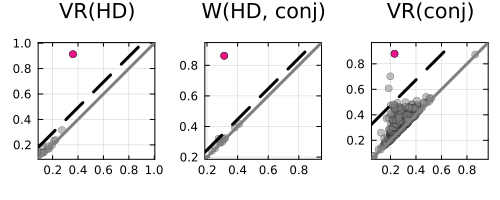

In [18]:
# plot persistence diagrams
witness_bar = 12
p1 = plot_PD(barcode_VR_HD, title = "VR(HD)", highlight = extension_P2["Ybar_rep_tau"], cutoff = HD_cutoff)
p2 = plot_PD(barcode_W_HD_conj, title = "W(HD, conj)", highlight = [witness_bar], cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "VR(conj)", highlight = extension_Q2["Ybar_rep_tau"], cutoff = conj_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (500, 200))

In [19]:
# save barcodes
directory = "birthtime_analogous_outputs/"
# writedlm(directory * "barcode_HD.csv",  barcode_VR_HD, ',')
# writedlm(directory * "barcode_conj.csv",  barcode_VR_conj, ',')
# writedlm(directory * "barcode_W_HD_conj.csv", barcode_W_HD_conj, ',')

In [20]:
# save all significant points and threshold
 # save(directory * "HD_conj_significant_PD.jld2", 
 #    "HD_selected", HD_idx,
 #    "HD_cutoff", HD_cutoff,
 #    "conj_selected", conj_idx,
 #    "conj_cutoff", conj_cutoff,
 #    "W_HD_conj_selected", W_idx,
 #    "W_HD_conj_cutoff", W_cutoff)

In [22]:
# save analogous pairs
# save(directory * "HD_conj_analogous_via_12.jld2",
#     "analogous_HD", extension_P2["Ybar_rep_tau"],
#     "analogous_conj", extension_Q2["Ybar_rep_tau"])